# **Búsqueda en Árboles de Juego**

Aprenderemos a implementar el algoritmo **Minimax con poda alfa-beta** para el juego *Conecta 4*.

En este juego de suma cero por turnos, cada jugador inserta en su turno una ficha por una de las columnas, que caen verticalmente hasta la última posición vacía de esa columna. El objetivo es conseguir que haya cuatro fichas de su mismo color en línea, ya sea horizontal, vertical o diagonalmente.

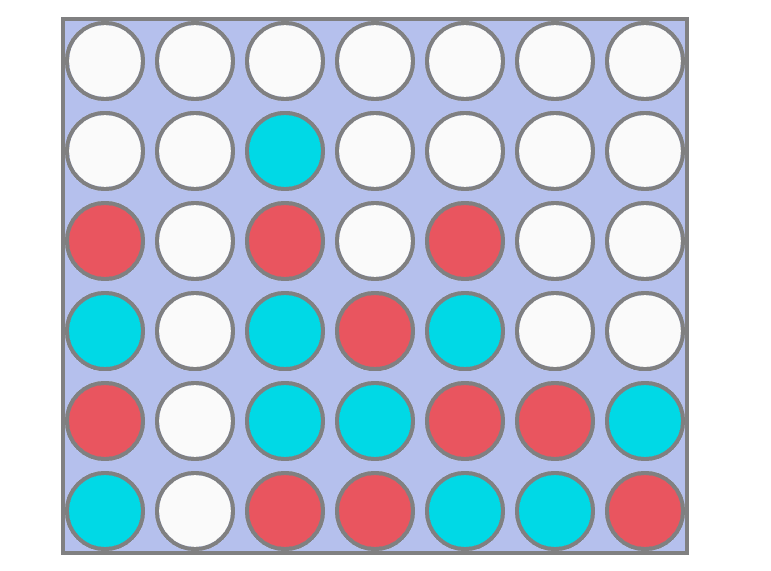

En este cuaderno se representan los estados, transiciones, funciones solución y heurística, así como la implementación de Minimax con poda alfa-beta necesaria para resolver el problema computacionalmente.

## **Parte Dependiente**: Conecta 4

Vamos a considerar el juego de Conecta 4 con un tablero de 6 filas y 7 columnas. En este juego:
- el jugador humano (MIN) se representa como **'X'**
- la máquina (MAX) se representa como **'O'**
- la casilla vacía se representa como un **'-'**

In [11]:
import numpy as np

# Tamaño del tablero
filas = 6
columnas = 7

# Jugadores
jugadores = {'X':1, 'O':2, '-':0}

# Función para crear un tablero vacío
def crear_tablero(filas, columnas):
  return np.zeros((filas, columnas), dtype=int)

# Función para imprimir el tablero
def imprimir_tablero(tablero):
  filas, columnas = tablero.shape
  for fila in range(filas):
    for col in range(columnas):
      if tablero[filas - 1 - fila][col] == 0:
        print(" - ", end="")
      elif tablero[filas - 1 - fila][col] == 1:
        print(" X ", end="")
      elif tablero[filas - 1 - fila][col] == 2:
        print(" O ", end="")
    print()
  print(' ' + '  '.join([str(i) for i in range(1, columnas+1)]))
  print()

imprimir_tablero(crear_tablero(filas,columnas))

ModuleNotFoundError: No module named 'numpy'

Por turnos, cada jugador va introduciendo una ficha alternativamente en cualquiera de las 7 columnas del tablero que se encuentren con alguna posición (fila) libre en ese momento, y esta ficha caerá hasta la posición (fila) más baja que se encuentre libre.

In [2]:
# Función para dejar caer una ficha en una columna
def dejar_ficha(tablero, fila, col, jugador):
  tablero[fila][col] = jugadores[jugador]

# Función para verificar si una columna está llena
def columna_llena(tablero, col):
  filas, columnas = tablero.shape
  return tablero[filas - 1][col] != 0

# Función para obtener la fila disponible en una columna
def obtener_fila_disponible(tablero, col):
  filas, columnas = tablero.shape
  for fila in range(filas):
    if tablero[fila][col] == 0:
      return fila
  return None

# Función para obtener las columnas válidas para el próximo movimiento
def columnas_validas(tablero):
  filas, columnas = tablero.shape
  columnas_validas = []
  for col in range(columnas):
    if not columna_llena(tablero, col):
      columnas_validas.append(col)
  return columnas_validas

# Función que devuelve los nuevos estados del tablero según los posibles movimientos del jugador
def movimientos(tablero, jugador):
  sucesores = []
  columnas_disponibles = columnas_validas(tablero)
  for col in columnas_disponibles:
    fila_disponible = obtener_fila_disponible(tablero, col)
    copia_tablero = tablero.copy()
    dejar_ficha(copia_tablero, fila_disponible, col, jugador)
    sucesores.append(copia_tablero)
  return sucesores, columnas_disponibles

El objetivo del juego Conecta 4 es alinear cuatro fichas consecutivas del mismo color (en horizontal, vertical o diagonal) sobre el tablero, ganando la partida el primero que lo consiga.

Si todas las columnas están llenas, pero nadie ha hecho una fila válida, hay empate.


In [3]:
# Función para verificar si un jugador ha ganado
def ganador(tablero, jugador):
  filas, columnas = tablero.shape
  # Verificar horizontalmente
  for fila in range(filas):
    for col in range(columnas - 3):
      if all(tablero[fila][col + i] == jugadores[jugador] for i in range(4)):
        return True

  # Verificar verticalmente
  for fila in range(filas - 3):
    for col in range(columnas):
      if all(tablero[fila + i][col] == jugadores[jugador] for i in range(4)):
        return True

  # Verificar en diagonal (ascendente)
  for fila in range(3, filas):
    for col in range(columnas - 3):
      if all(tablero[fila - i][col + i] == jugadores[jugador] for i in range(4)):
        return True

  # Verificar en diagonal (descendente)
  for fila in range(filas - 3):
    for col in range(columnas - 3):
      if all(tablero[fila + i][col + i] == jugadores[jugador] for i in range(4)):
        return True

  return False

# Función para verificar si el juego ha terminado e indicar el resultado
def juego_terminado(tablero):
  if ganador(tablero, 'X'):
    return (True, 'X')
  elif ganador(tablero,'O'):
    return (True,'O')
  elif len(columnas_validas(tablero)) == 0:
    return (True,'-')
  else:
    return (False,None)

Se propone usar el heurístico es  H = L(O) - L(X), siendo L la suma del número de fichas de ese color en el tablero por cada línea posible. En el caso de que una misma ficha forme parte de más de una línea, se sumará más de una vez, una por cada línea posible.

In [4]:
# Función para evaluar el tablero
def evaluar_tablero(tablero, jugador):
  puntuacion = 0

  # Evaluar horizontalmente
  for fila in range(filas):
    for col in range(columnas - 3):
      ventana = [tablero[fila][col + i] for i in range(4)]
      puntuacion += evaluar_ventana(ventana, jugador)

  # Evaluar verticalmente
  for fila in range(filas - 3):
    for col in range(columnas):
      ventana = [tablero[fila + i][col] for i in range(4)]
      puntuacion += evaluar_ventana(ventana, jugador)

  # Evaluar en diagonal (ascendente)
  for fila in range(3, filas):
    for col in range(columnas - 3):
      ventana = [tablero[fila - i][col + i] for i in range(4)]
      puntuacion += evaluar_ventana(ventana, jugador)

  # Evaluar en diagonal (descendente)
  for fila in range(filas - 3):
    for col in range(columnas - 3):
      ventana = [tablero[fila + i][col + i] for i in range(4)]
      puntuacion += evaluar_ventana(ventana, jugador)

  return puntuacion

# Función para evaluar una ventana de 4 fichas
def evaluar_ventana(ventana, jugador):
  rival = 'X' if jugador == 'O' else 'O'
  fichas_jugador = ventana.count(jugadores[jugador])
  fichas_rival = ventana.count(jugadores[rival])
  fichas_vacias = ventana.count(jugadores['-'])
  if fichas_jugador == 4-fichas_vacias:
    return fichas_jugador
  elif fichas_rival == 4-fichas_vacias:
    return -fichas_rival
  return 0

## **Parte Independiente**: Algoritmo Minimax con poda alfa beta

Ahora implementamos el algoritmo **Minimax con poda alfa-beta**.

Cuando nos encontramos en un nodo MAX, la llamada a minimax se hace con el tablero insertando previamente la ficha, disminuyendo en uno la profundidad, con los valores de alfa y beta que ha recibido y con False para indicar que en la próxima llamada le toca a un nodo MIN. Se actualiza alfa si el valor devuelto por el nodo hijo es >= alfa y se poda si alfa es >= beta.

Cuando nos encontramos con un nodo MIN, la llamada a minimax se hace igual pero con True para indicar que en la próxima llamada le toca a un nodo MAX. Se actualiza beta si el valor devuelto por el nodo hijo es <= beta y se poda si alfa es >= beta.

In [5]:
# Función principal del algoritmo Minimax con poda alfa-beta
def minimax_alpha_beta(tablero, sucesores, terminada, heuristica, profundidad, alpha, beta, MIN, MAX, is_max=True):
  fin, ganador = terminada(tablero)
  if fin:
    if ganador == MAX:
      return (None, 100000000000000)
    elif ganador == MIN:
      return (None, -10000000000000)
    else:
      return (None, 0)
  elif profundidad == 0:
    return (None, heuristica(tablero, MAX))

  if is_max:
    valor_max = -float("inf")
    nuevos_estados, jugadas = sucesores(tablero,MAX)
    jugada_elediga = np.random.choice(jugadas)
    for jugada, estado in zip(jugadas, nuevos_estados):
      _, nuevo_valor = minimax_alpha_beta(estado, sucesores, terminada, heuristica, profundidad - 1, alpha, beta, MIN, MAX, False)
      if nuevo_valor > valor_max:
        valor_max = nuevo_valor
        jugada_elegida = jugada
      alpha = max(alpha, valor_max)
      if alpha >= beta:
        break
    return jugada_elegida, valor_max
  else: # is MIN
    valor_min = float("inf")
    nuevos_estados, jugadas = sucesores(tablero,MIN)
    jugada_elediga = np.random.choice(jugadas)
    for jugada, estado in zip(jugadas, nuevos_estados):
      _, nuevo_valor = minimax_alpha_beta(estado, sucesores, terminada, heuristica, profundidad - 1, alpha, beta, MIN, MAX, True)
      if nuevo_valor < valor_min:
        valor_min = nuevo_valor
        jugada_elegida = jugada
      beta = min(beta, valor_min)
      if alpha >= beta:
        break
    return jugada_elegida, valor_min

# Probando el juego Conecta 4
En el programa principal creamos el tablero inicial y entramos en un bucle hasta que termine el juego
En dicho bucle:
- Imprimimos el tablero
- Si le toca al humano pedimos su jugada
- Si le toca a la máquina llamamos a minimax con poda alfa beta con una determinada profundidad (probamos con 5), con alfa = -inf y con beta = inf
- Por último, imprimimos el resultado del juego (gana humano, gana máquina o tablas)

In [ ]:
# Juego principal
tablero = crear_tablero(filas, columnas)
jugador = 'X'

while not juego_terminado(tablero)[0]:
  if jugador == 'X':
    # Turno del jugador humano
    imprimir_tablero(tablero)
    col = int(input("Elige una columna para dejar tu ficha (1-"+str(columnas)+"): ")) - 1
    if col not in columnas_validas(tablero):
      print("Columna no válida. Intenta de nuevo.")
    else:
      fila = obtener_fila_disponible(tablero, col)
      dejar_ficha(tablero, fila, col, jugador)
      jugador = 'O'

  else:
    # Turno de la IA
    col, _ = minimax_alpha_beta(tablero, movimientos, juego_terminado, evaluar_tablero, 5, -float("inf"), float("inf"), 'X', 'O', True)
    fila = obtener_fila_disponible(tablero, col)
    print(f"La IA dejó una ficha en la columna {col + 1}.")
    dejar_ficha(tablero, fila, col, jugador)
    jugador = 'X'

imprimir_tablero(tablero)
if ganador(tablero, 'X'):
    print("¡Has ganado!")
elif ganador(tablero, 'O'):
    print("¡La IA ha ganado!")
else:
    print("¡Empate!")


## **Ejercicio 1**

Implementar el algoritmo Minimax "sin poda alfa-beta" para el juego Conecta 4.

## **Ejercicio 2**

Diseñar las funciones necesarias para resolver el juego Tres en Raya usando los algoritmos anteriores (Minimax y Minimax con poda alfa-beta).

## **Prácticas con el código proporcionado**

Para cada uno de los juegos y para cada uno de los algoritmos (Minimax y Minimax con poda alfa-beta):

1. Definir un estado concreto del tablero de juego en el que haya el mismo número de jugadas realizadas por humano y por la máquina

2. Introducir una jugada del humano (estado inicial)

3. Obtener la jugada seleccionada por la máquina

4. Desarrollar en papel el algoritmo elegido partiendo del estado inicial y comprobar que obtenemos el mismo resultado que el obtenido por la máquina